In [1]:
import json, shutil, random
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split

In [2]:
base      = Path("indofashion_dataset")       
json_loc   = base/"test_data.json"        
image_loc   = base/"images/test"   

In [3]:
sandbox   = Path("indofashionSandbox")
img_output      = sandbox/"train_sand"
json_output = sandbox/"indofashion_metadata.json"
csv_output  = sandbox/"indofashion_metadata.csv"

img_output.mkdir(parents=True, exist_ok=True)

In [4]:
records = []
with open(json_loc, "r") as f:
    for line in f:
        rec = json.loads(line)
        img_path = Path(rec["image_path"])
        rec["image_id"] = img_path.stem
        records.append(rec)

df_full = pd.DataFrame(records)
print("Total images:", len(df_full))
print("Classes:", df_full["class_label"].nunique(), df_full["class_label"].unique())

Total images: 7500
Classes: 15 ['saree' 'blouse' 'dhoti_pants' 'dupattas' 'gowns' 'kurta_men'
 'leggings_and_salwars' 'lehenga' 'mojaris_men' 'mojaris_women'
 'nehru_jackets' 'palazzos' 'petticoats' 'sherwanis' 'women_kurta']


In [7]:
exclude = {"petticoats", "mojaris_men", "mojaris_women", "dupattas"}
df_filtered = df_full[~df_full["class_label"].isin(exclude)].copy()
sample_size = 2000

try:
    df_sample, _ = train_test_split(
        df_filtered,
        train_size=sample_size,
        stratify=df_filtered["class_label"],
        random_state=42
    )
except Exception:
    df_sample = ( df_filtered
        .groupby("class_label", group_keys=False)
        .apply(lambda g: g.sample(
            max(1, int(sample_size * len(g)/len(df_filtered))), 
            random_state=42
        ))
        .reset_index(drop=True)
    )

    if len(df_sample) > sample_size:
        df_sample = df_sample.sample(sample_size, random_state=42)
    elif len(df_sample) < sample_size:
        extra = df_filtered.drop(df_sample.index).sample(sample_size - len(df_sample), random_state=42)
        df_sample = pd.concat([df_sample, extra], ignore_index=True)

print(f"Final sample: {len(df_sample)} images")
print("Included classes:", df_sample["class_label"].unique())


Final sample: 2000 images
Included classes: ['lehenga' 'nehru_jackets' 'women_kurta' 'kurta_men' 'gowns' 'dhoti_pants'
 'blouse' 'saree' 'sherwanis' 'palazzos' 'leggings_and_salwars']


In [9]:
for _, row in df_sample.iterrows():
    src = base/row["image_path"]
    dst = img_output/f"{row['image_id']}{src.suffix}"
    shutil.copy2(src, dst)
print("Shifted")

Shifted


In [10]:
with open(json_output, "w") as f:
    for rec in df_sample.to_dict(orient="records"):
        out = {
            "image_id": rec["image_id"],
            "class_label": rec["class_label"],
            "brand": rec["brand"],
            "product_title": rec["product_title"]
        }
        f.write(json.dumps(out) + "\n")

df_sample[["image_id","class_label","brand","product_title"]].to_csv(
    csv_output, index=False
)
print("done")

done


Exploring IndoFashion

In [12]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

In [14]:
metadata_path = "indofashionSandbox/indofashion_metadata.csv"
df = pd.read_csv(metadata_path)
df.head()

,image_id,class_label,brand,product_title
0,3826,lehenga,Chhabra 555,Peach-Coloured &amp; Golden Sequinned Made to ...
1,5230,nehru_jackets,Ethnix by Raymond,"Mens Regular Fit BundiRTUA00615-B9100, fancy b..."
2,7296,women_kurta,Aks,womens Kurta Sets
3,2785,kurta_men,DEYANN,Men Navy Blue &amp; White Solid Kurta with Pyj...
4,2430,gowns,ADESA,Red A-Line Cotton Striped Kurti for Women


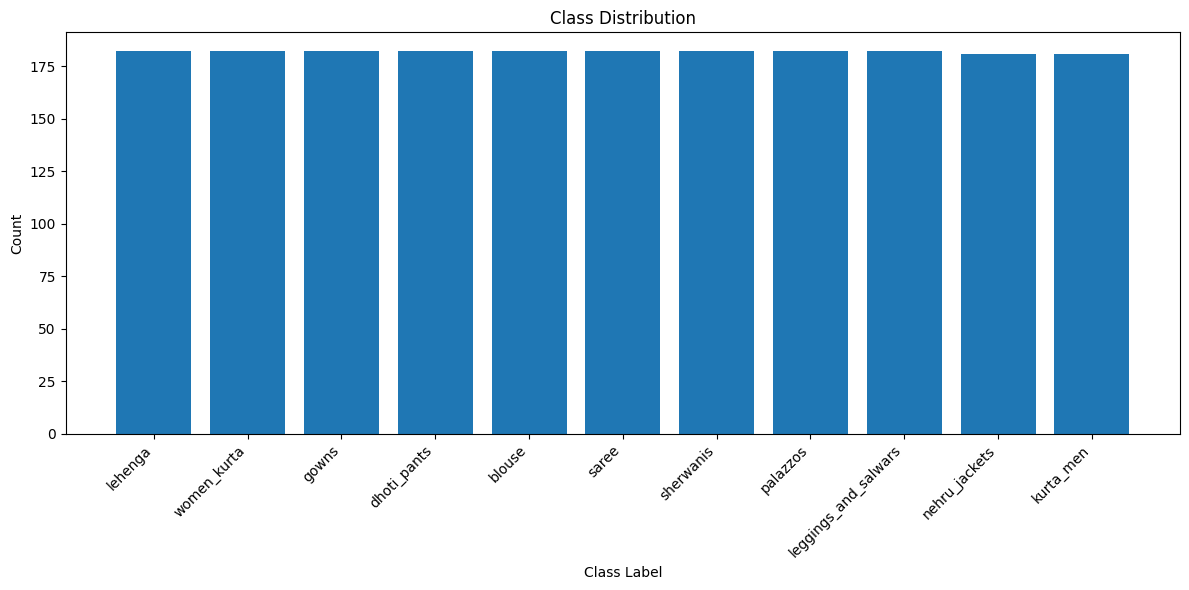

In [16]:
class_counts = df["class_label"].value_counts()
plt.figure(figsize=(12,6))
plt.bar(class_counts.index, class_counts.values)
plt.title("Class Distribution")
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


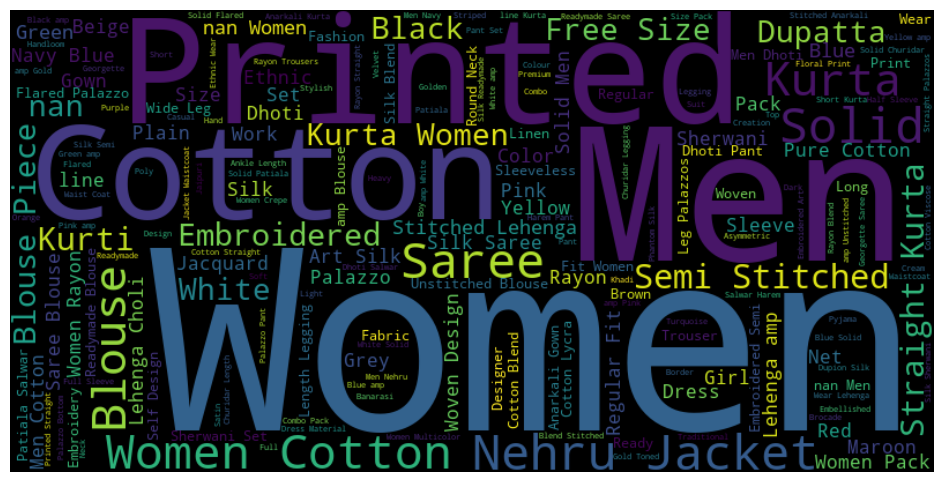

In [21]:
from wordcloud import WordCloud

title = " ".join(df["product_title"].astype(str))
wc = WordCloud(width=800, height=400, background_color="black").generate(title)
plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()